##Aluno: Lucas Barbosa dos Santos

##Atividade
Responda as perguntas abaixo com base no códido do notebook 3.1-LogisticRegressionIris.ipynb.

1. Observando o gráfico de máxima probabilidade, responda:
1. Qual é a amostra classificada corretamente, com maior probabilidade?
2. Qual é a amostra classificada erradamente, com maior probabilidade?
3. Qual é a amostra classificada corretamente, com menor probabilidade?
4. Qual é a amostra classificada erradamente, com menor probabilidade?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
- http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

In [1]:
#Pacotes
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

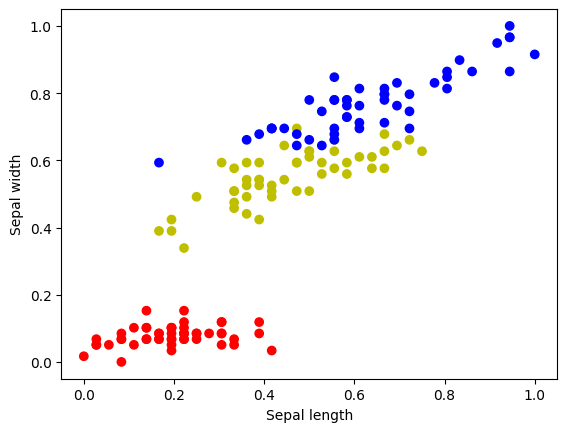

In [11]:
# Leitura, normalização e visualização dos dados
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

In [12]:
#Preparando os dados para o Pythorch
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [25]:
#Construindo o modelo da rede
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [26]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.4602,  0.4955],
                      [-0.3390,  0.5438],
                      [-0.1495,  0.5592]])),
             ('bias', tensor([-0.3598,  0.7049, -0.3108]))])

In [27]:
#Fazendo um predict
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.4285,  0.6664, -0.3061],
        [-0.4029,  0.6852, -0.2978],
        [-0.3858,  0.6949, -0.2989],
        [-0.3562,  0.7227, -0.2758]], grad_fn=<AddmmBackward0>)

In [28]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.1953, 0.5839, 0.2208],
        [0.1969, 0.5844, 0.2187],
        [0.1985, 0.5849, 0.2165],
        [0.1990, 0.5853, 0.2157]], grad_fn=<SoftmaxBackward0>)

In [29]:
# Calculando as probabilidades com Softmax
F.softmax(out,dim=1)*100

tensor([[19.5347, 58.3866, 22.0787],
        [19.6862, 58.4445, 21.8693],
        [19.8524, 58.4945, 21.6532],
        [19.9002, 58.5343, 21.5655]], grad_fn=<MulBackward0>)

In [30]:
#Predição da classe
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([1, 1, 1, 1])
tensor([0.5839, 0.5844, 0.5849, 0.5853], grad_fn=<MaxBackward0>)


In [31]:
#Treinamento
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

In [33]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.2071717530488968


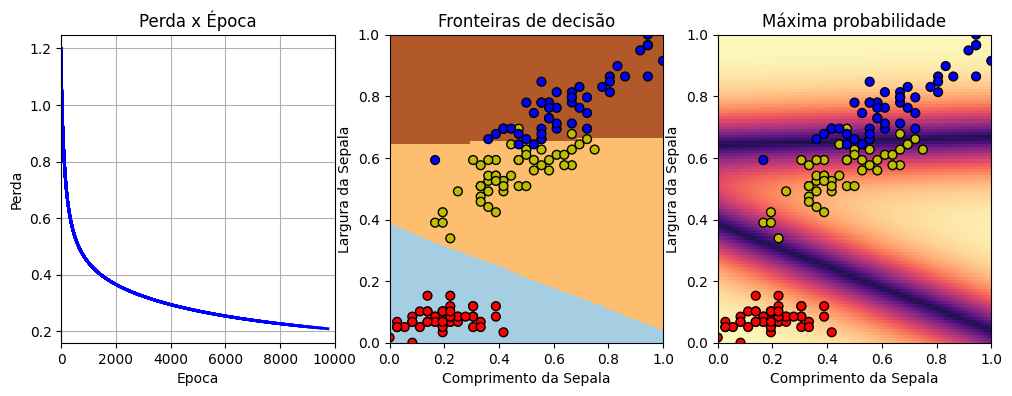

In [34]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

In [35]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.3618, -14.1607],
                      [  1.4518,  -0.1357],
                      [  0.9614,  15.8950]])),
             ('bias', tensor([ 7.0193,  1.6357, -8.6206]))])

In [36]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


In [37]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


2 - 2x3 = 6 pesos, 3 bias, 9 parâmetros contando com o bias

3 - possui 2 entradas e 3 saídas

4 - é a proporção entre a diagonal principal, por todos os elementos da matriz

5 -  o índice da maior valor de cada linha — isso representa a classe predita.

saídas: é o tensor de forma [N, C], onde:

N = número de amostras (lotes),

C = número de classes.

dim=1: significa que queremos o valor máximo por linha, ou seja, por amostra.